<a href="https://colab.research.google.com/github/nexossama/Adversarial-Exemples-in-Computer-Vision/blob/Jupiter/Fooling_AI_image_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fooling AI image classifiers**
#### by Outmani Ossama
- The code bellow is the implementation of the study paper **"Fooling AI image classifiers"** by the author **Outmani Ossama**, where the goal is to test the resiliance of MobileNet V2 model against adversarial attacks
- The code bellow is originially taken from the Tensorflow documentation , modified and adapted to suite our study , and being applicable to the all 1000 imageNet classes  
link : https://www.tensorflow.org/tutorials/generative/adversarial_fgsm

- The full project Github repo : https://github.com/nexossama/Adversarial-Exemples-in-Computer-Vision/tree/main

- Download the paper from here : https://github.com/nexossama/Adversarial-Exemples-in-Computer-Vision/blob/main/Fooling%20AI%20Image%20Classifiers.pdf

- Contact : https://www.linkedin.com/in/ossama-outmani/

# A. Introduction

## 0. download essential files

In [ ]:
import requests
import os
def download_from_link(link,filename=None):
  # Download the image
  response = requests.get(link)
  if filename is None:
    filename=os.path.basename(link)
  # Check for successful download
  if response.status_code == 200:
    with open(filename, 'wb') as f:
      f.write(response.content)
  else:
      print(f"Error downloading {filename}: {response.status_code}")

download_from_link("https://raw.githubusercontent.com/nexossama/Adversarial-Exemples-in-Computer-Vision/main/Cat.jpg","Cat.jpg")
download_from_link("https://raw.githubusercontent.com/nexossama/Adversarial-Exemples-in-Computer-Vision/main/imageNet.json","imageNet.json")
print("done")


## 1. Getting used with the model

In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np

###  1.a. load the model

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,weights='imagenet')
pretrained_model.trainable = False

# function to get the predicted label
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14536120/14536120 [==============================] - 0s 0us/step


###  1.b. get the image

In [ ]:
# comment this cell if you are runnning this notebook locally
from google.colab import files

def read_image(image_path=None):
  if image_path is None:
    uploaded = files.upload()
    image_path=list(uploaded.keys())[0]
  image_raw = tf.io.read_file(image_path)
  image = tf.image.decode_image(image_raw)
  return image


In [ ]:
# comment this cell if you are runnning this notebook in Collab
# def read_image(image_path=None):
#   if image_path is None:
#     image_path=input("Please enter the image path")
#   image_raw = tf.io.read_file(image_path)
#   image = tf.image.decode_image(image_raw)
#   return image

In [ ]:
# default image
image = read_image(image_path="Cat.jpg")

# to upload your own image
# image = read_image()

###  1.c. Preprocess the image

In [ ]:
#used only to preprocess the original image
def preprocess_org(photo):
  resized_image=tf.image.resize(photo,(224,224))
  resized_image=resized_image[None,...]
  return resized_image

In [ ]:
#preprecess the image to be compatible with the model
def preprocess(photo):
  resized_image=tf.image.resize(photo,(224,224))
  resized_image=resized_image[None,...]
  preprocessed_image = tf.keras.applications.mobilenet_v2.preprocess_input(resized_image)
  return preprocessed_image

In [ ]:
preprocessed_image=preprocess(image)

###  1.d. Predict the label

In [ ]:
import json

#return one_hot encoding corresponding to given label
def one_hot_from_label(label,size=1000):
  with open("imageNet.json","r") as f:
    labels_dict=json.load(f)
  index=labels_dict[label]
  label_array = tf.one_hot(index, size)
  label_array = tf.reshape(label_array, (1,size))

  return label_array

In [ ]:
#probilities of each label for the given image
def mobilenet_v2_predict(image):
  preprocessed_image=preprocess(image)
  predictions=pretrained_model.predict(preprocessed_image,verbose="0")
  decoded_prediction=decode_predictions(predictions,top=1)[0]

  loss_object = tf.keras.losses.CategoricalCrossentropy()
  label=decoded_prediction[0][1]
  one_hot_label=one_hot_from_label(label)
  loss = loss_object(one_hot_label, predictions)
  return {"predictions" : predictions ,"loss" : loss}

In [ ]:
# get label and confidence level for an image
def get_class(probabilities):
  _ , label , confidence = decode_predictions(probabilities,top=1)[0][0]
  return {"label":label,"confidence":confidence}

35363/35363 [==============================] - 0s 0us/step


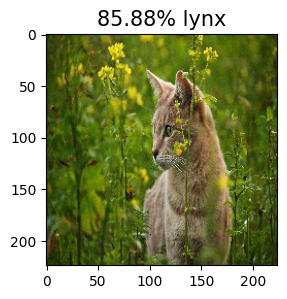

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (3, 3)
mpl.rcParams['axes.grid'] = False

#display given image along with prediction information
def display_prediction(image,xlabel=None):
    plt.figure()
    img_ajusted=np.asarray(preprocess_org(image))[0]
    plt.imshow(img_ajusted/255)
    label,confidence=get_class(mobilenet_v2_predict(image)["predictions"]).values()
    plt.title(f"{confidence*100:.2f}% {label}",fontsize="15")
    if xlabel is not None:
        plt.xlabel(xlabel,fontsize="13")

display_prediction(image)

## 2. Building Adversarial exemples

In [ ]:
#generate noise for a given image
def generate_adversarial_noise(image,type="sign"):
    """
    type : "sign" or "norm"
          where "sign" defines the standard FGSM technique and "norm" stands for the normalized version of FGSM
    """
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    label=get_class(mobilenet_v2_predict(image)["predictions"])["label"]
    one_hot_label=one_hot_from_label(label)
    image=preprocess(image)
    with tf.GradientTape() as tape:
      tape.watch(image)
      predictions = pretrained_model(image)
      loss = loss_object(one_hot_label, predictions)
    gradient = tape.gradient(loss, image)    # Get the gradients of the loss with respect to the input image.

    if type=="sign": # Get the sign of the gradients to create the perturbation
      signed_grad = tf.sign(gradient)
      return signed_grad

    elif type=="norm": # Get the normalize version of the gradients to create the perturbation
      max_grad = tf.reduce_max(tf.math.abs(gradient))
      return gradient/max_grad

## 3. Visualising

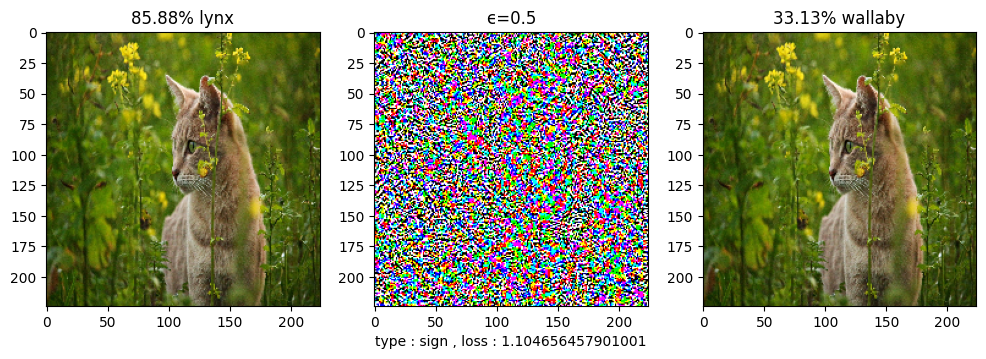

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = False

#display before and after and noise of a given image after FGSM
def display_exemples(image,epsilon=[0.07],type="sign"):
  """
    epsilon : list
      list of all epsilons to try at once

    type : "sign" or "norm"
          where "sign" defines the standard FGSM technique and "norm" stands for the normalized version of FGSM
  """
  i=1
  for e in epsilon :
    plt.figure(i)
    plt.subplot(231)
    noise=generate_adversarial_noise(image,type=type)
    img_ajusted=np.asarray(preprocess_org(image)).reshape(224,224,3)
    plt.imshow(img_ajusted/255)
    prediction=mobilenet_v2_predict(image)
    label,confidence=get_class(mobilenet_v2_predict(image)["predictions"]).values()
    plt.title(f"{confidence*100:.2f}% {label}")
    label=get_class(mobilenet_v2_predict(image)["predictions"])["label"]


    plt.subplot(233)
    adv_image=preprocess_org(image)+e*noise
    adv_image=tf.clip_by_value(adv_image,0,255)
    prediction_couple=mobilenet_v2_predict(adv_image[0])["predictions"]
    label,confidence=get_class(prediction_couple).values()
    plt.title(f"{confidence*100:.2f}% {label}")
    adv_ajusted=adv_image[0]
    loss_object = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0)
    one_hot_label=one_hot_from_label(label)
    loss = loss_object(one_hot_label, prediction_couple)

    plt.imshow(adv_ajusted/tf.reduce_max(tf.math.abs(adv_ajusted)))
    # plt.xlabel(f"type : {type} , loss : {loss}")

    plt.subplot(232)
    plt.title(f"ϵ={e}")
    plt.xlabel(f"type : {type} , loss : {loss}")

    plt.imshow(np.asarray(noise*0.5+0.5).reshape(224,224,3))

    i+=1


display_exemples(image,[0.5],"sign")

# B. Paper Experiments

In [ ]:
img=read_image("Cat.jpg")

## Experiment 1 : FGSM

applying FGSM to an image

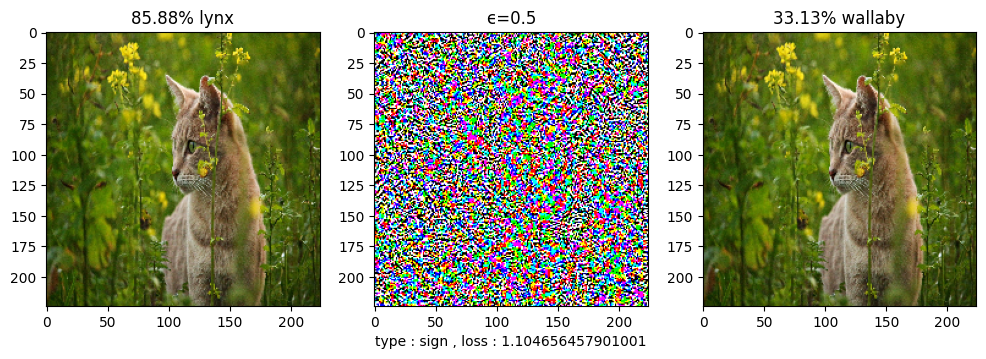

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = False
display_exemples(img,epsilon=[0.5],type="sign")

## Experiment 2 : FGSM with multiple epsilons

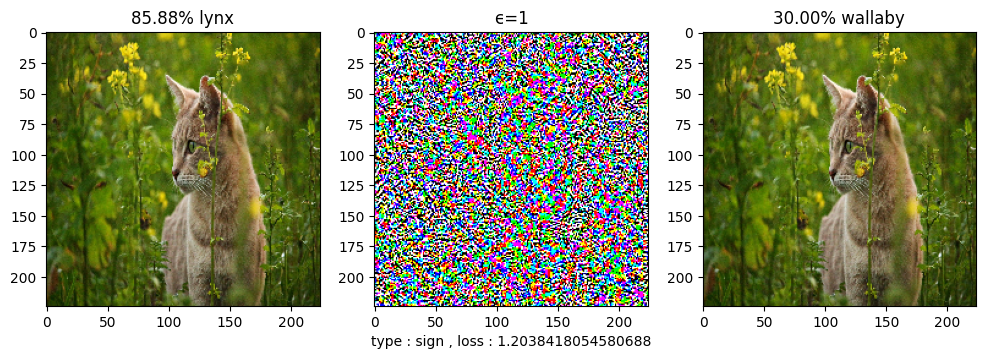

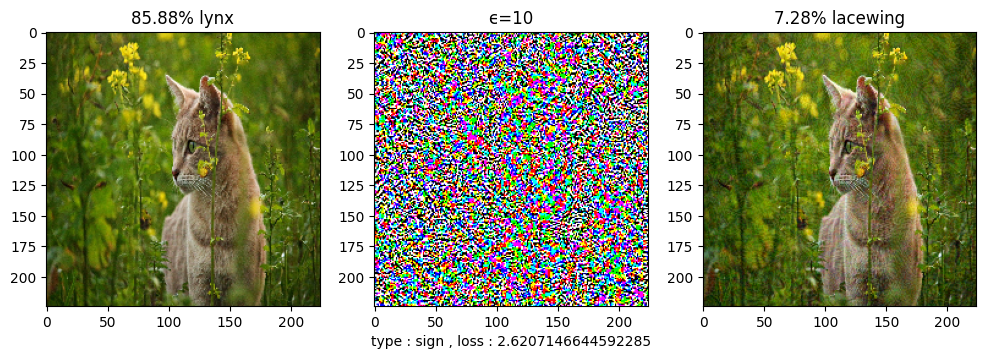

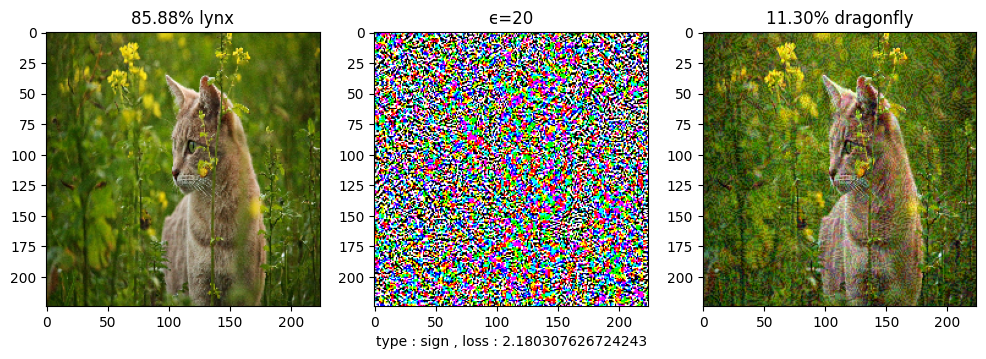

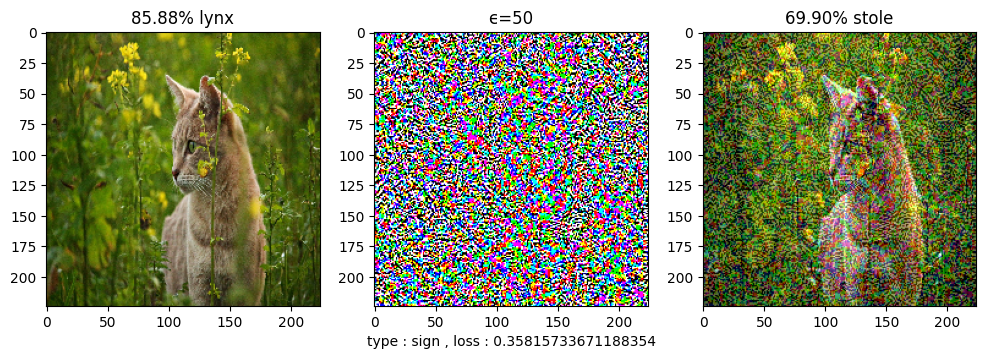

In [ ]:
display_exemples(img,epsilon=[1,10,20,50],type="sign")

## Experiment 3 : optimizing FGSM

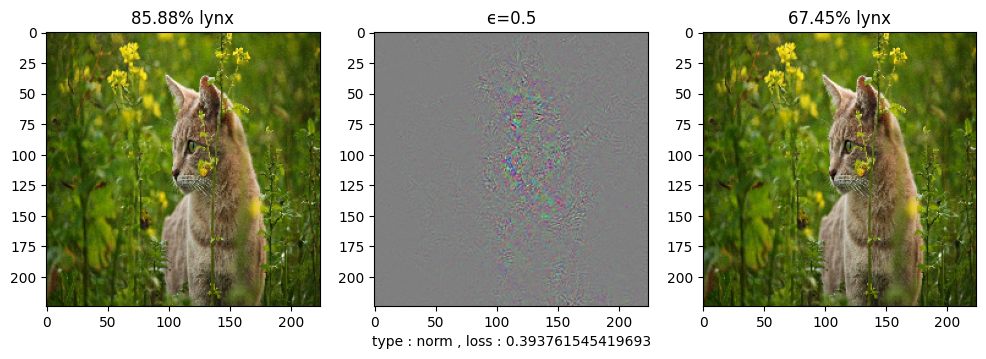

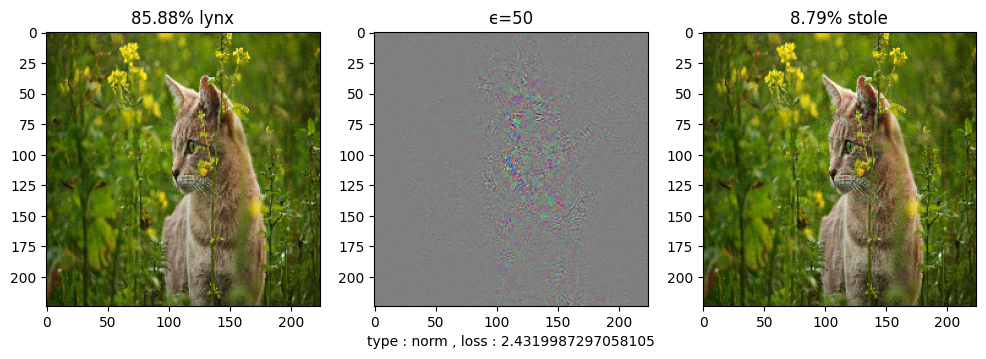

In [ ]:
display_exemples(img,epsilon=[0.5,50],type="norm")

## Experiment 4 : Testing on Real-life images

###  1. Download printed and scanned images

In [ ]:
!mkdir assets

In [ ]:
%cd assets
download_from_link("https://raw.githubusercontent.com/nexossama/Adversarial-Exemples-in-Computer-Vision/main/assets/original.jpg")
download_from_link("https://raw.githubusercontent.com/nexossama/Adversarial-Exemples-in-Computer-Vision/main/assets/sign0.5.jpg")
download_from_link("https://raw.githubusercontent.com/nexossama/Adversarial-Exemples-in-Computer-Vision/main/assets/sign1.jpg")
download_from_link("https://raw.githubusercontent.com/nexossama/Adversarial-Exemples-in-Computer-Vision/main/assets/sign10.jpg")
download_from_link("https://raw.githubusercontent.com/nexossama/Adversarial-Exemples-in-Computer-Vision/main/assets/norm10.jpg")
download_from_link("https://raw.githubusercontent.com/nexossama/Adversarial-Exemples-in-Computer-Vision/main/assets/norm50.jpg")

print("done")
%cd ..



/content/assets
done
/content


Original printed and photographed image

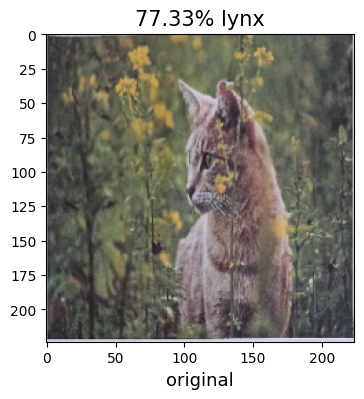

In [ ]:
mpl.rcParams['figure.figsize'] = (4, 4)

image=read_image("assets/original.jpg")
display_prediction(image,xlabel="original")

Adversarial example generated with FGSM with Ɛ=0.5 printed and photographed

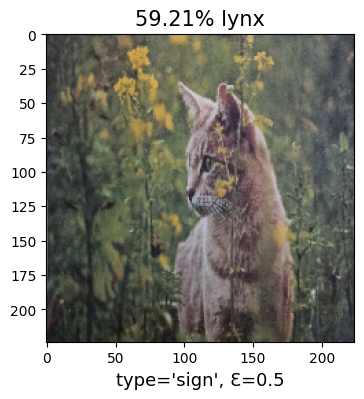

In [ ]:
image=read_image("assets/sign0.5.jpg")
display_prediction(image,xlabel="type='sign', Ɛ=0.5")

Adversarial example generated with FGSM with Ɛ=1 printed and photographed

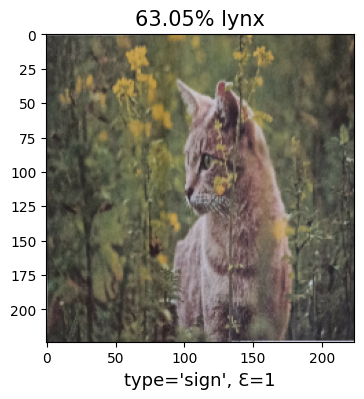

In [ ]:
image=read_image("assets/sign1.jpg")
display_prediction(image,xlabel="type='sign', Ɛ=1")

Adversarial example generated with FGSM with Ɛ=10 printed and photographed

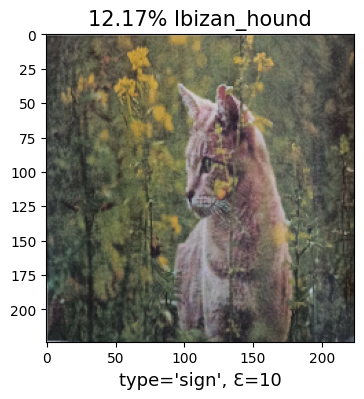

In [ ]:
image=read_image("assets/sign10.jpg")
display_prediction(image,xlabel="type='sign', Ɛ=10")

Adversarial example generated with Normalized version of FGSM with Ɛ=10 printed and photographed

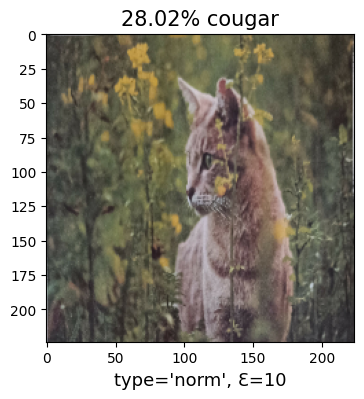

In [ ]:
image=read_image("assets/norm10.jpg")
display_prediction(image,xlabel="type='norm', Ɛ=10")

Adversarial example generated with Normalized version of FGSM with Ɛ=50 printed and photographed

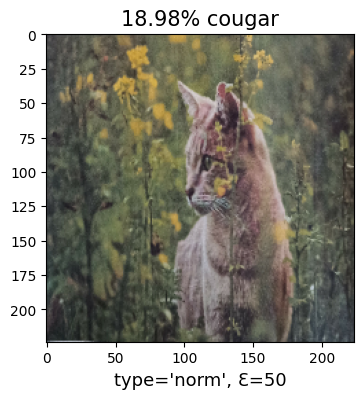

In [ ]:
image=read_image("assets/norm50.jpg")
display_prediction(image,xlabel="type='norm', Ɛ=50")

# C. Generate and Download

In [ ]:
import os
from google.colab import files

def download_adversarial_image(image_path,type="sign",epsilon=10,filename=None,colab=False):
    """
    image_path : str
        path to the source image

    type : "sign" or "norm"
        where "sign" defines the standard FGSM technique and "norm" stands for the normalized version of FGSM

    epsilon : float
      list of all epsilons to try at once

    filename : str
      name of the generated image , if none ,it will be same as original

    colab : bool
      True if running the nptebook in colab and need to download the image locally , False if running the notebook locally
  """
    image=read_image(image_path)
    noise=generate_adversarial_noise(image,type=type)
    adv_image=preprocess_org(image)+epsilon*noise
    adv_image=tf.clip_by_value(adv_image,0,255)
    im = tf.image.resize(adv_image, (image.shape[0], image.shape[1]))
    if filename is None :
      filename=os.path.basename(image_path)
    tf.keras.preprocessing.image.save_img(filename,im[0])
    if colab:
      files.download(filename)
    print("done")


In [ ]:
download_adversarial_image("Cat.jpg","sign",filename="generatedCat.jpg",colab=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

done
